In [45]:
import numpy as np
from PIL import Image
import cv2
import matplotlib.pyplot as plt

In [46]:
img = cv2.imread('carte-grise-specimen_a4.jpg')
img = np.array(Image.fromarray(img.copy()).rotate(65,resample=Image.BICUBIC, expand=True))
img = cv2.resize(img, (920, 1600))

In [47]:
cv2.imshow("Original",img)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [48]:
img_original = img.copy()
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
gray = cv2.bilateralFilter(gray,20,30,30)

In [49]:
edged = cv2.Canny(gray,10,20)

In [50]:
cv2.imshow("edged",edged)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [51]:
gray_copy = np.stack((gray,)*3,axis=-1)
edged_copy = np.stack((edged,)*3,axis=-1)

In [52]:
print(img_original.shape)
print(gray_copy.shape)
print(edged_copy.shape)

(1600, 920, 3)
(1600, 920, 3)
(1600, 920, 3)


In [53]:
img_hor = np.hstack((img_original,gray_copy,edged_copy))

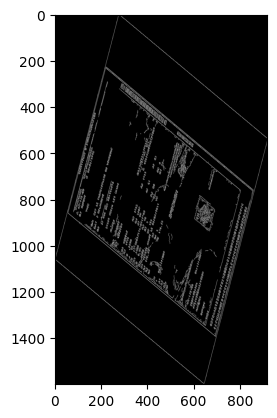

In [54]:
plt.imshow(edged_copy)


In [55]:
cv2.imshow("img_hor",img_hor)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [56]:
contours, hierarchy = cv2.findContours(edged.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contours = sorted(contours, key=cv2.contourArea, reverse=True)

In [57]:
# for i in contours :
#     cv2.drawContours(img,[i],-1,(0,0,255),3)

In [58]:
cv2.imshow("Original",img)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [59]:

def biggest_contour(contours):
    biggest = np.array([])
    max_area = 0
    for i in contours:
        area = cv2.contourArea(i)
        if area > 100:
            peri = cv2.arcLength(i, True)
            approx = cv2.approxPolyDP(i, 0.015 * peri, True)
            if area > max_area and len(approx) == 4:
                biggest = approx
                max_area = area
    return biggest

[[[ 276    1]]

 [[   1 1062]]

 [[ 643 1598]]

 [[ 918  537]]]


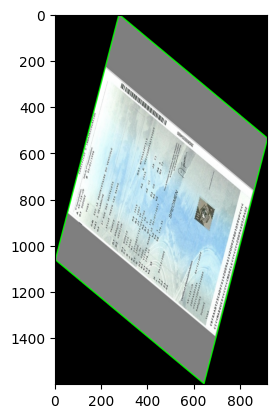

In [60]:
biggest = biggest_contour(contours)
print(biggest)
cv2.drawContours(img, [biggest], -1, (0, 255, 0), 3)
plt.imshow(img)

In [61]:
points = biggest.reshape(4, 2)
input_points = np.zeros((4, 2), dtype="float32")

In [62]:

points_sum = points.sum(axis=1)
input_points[0] = points[np.argmin(points_sum)]
input_points[3] = points[np.argmax(points_sum)]

points_diff = np.diff(points, axis=1)
input_points[1] = points[np.argmin(points_diff)]
input_points[2] = points[np.argmax(points_diff)]

In [63]:
(top_left, top_right, bottom_right, bottom_left) = input_points
bottom_width = np.sqrt(((bottom_right[0] - bottom_left[0]) ** 2) + ((bottom_right[1] - bottom_left[1]) ** 2))
top_width = np.sqrt(((top_right[0] - top_left[0]) ** 2) + ((top_right[1] - top_left[1]) ** 2))
right_height = np.sqrt(((top_right[0] - bottom_right[0]) ** 2) + ((top_right[1] - bottom_right[1]) ** 2))
left_height = np.sqrt(((top_left[0] - bottom_left[0]) ** 2) + ((top_left[1] - bottom_left[1]) ** 2))

# Output image size
max_width = int(460)
# max_height = max(int(right_height), int(left_height))
max_height = int(800)  # for A4

In [64]:
converted_points = np.float32([[0, 0], [max_width, 0], [0, max_height], [max_width, max_height]])

matrix = cv2.getPerspectiveTransform(input_points, converted_points)
img_output = cv2.warpPerspective(img_original, matrix, (max_width, max_height))

In [65]:
img_hor = np.hstack((img_original, gray_copy, edged_copy, img))
cv2.imshow("Contour detection", img_hor)
cv2.waitKey(0)
cv2.destroyAllWindows()


In [66]:
cv2.imshow("Warped perspective", img_output)
cv2.waitKey(0)
cv2.destroyAllWindows()

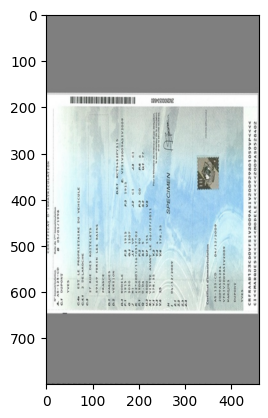

In [67]:

plt.imshow(img_output)